# Magnaprobe EDA (TOA5 export) — v2

This notebook explores a Campbell Scientific **TOA5** export from a Magnaprobe snow depth survey, performs basic QC, and produces quick-look plots (histogram + maps).

## QC rule (agreed)
Treat these as invalid (calibration / errors) and drop from analysis:
- any depth **< 0 cm**
- any depth **> 129 cm**


Loading MagnaProbe data...

Cleaning data...
Original measurements: 142
Valid measurements: 138
Removed (calibration/invalid): 4

Calculating statistics...

Summary Statistics:
  count: 138.00
  mean: 36.35
  median: 37.48
  std: 8.98
  min: 15.43
  max: 52.34
  q25: 29.64
  q75: 42.88

Generating histogram...
Histogram saved to: snow_depth_histogram.png

Generating spatial map...


/Users/ibrahim/.pyenv/versions/3.11.5/lib/python3.11/site-packages/contextily/tile.py:662: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


Spatial map saved to: snow_depth_map.png

Generating interactive map...
Map center: Lat=43.932853, Lon=-115.667555
Interactive map saved to: snow_depth_interactive_map.html

Done! Check output files for visualizations.
  - snow_depth_histogram.png
  - snow_depth_map.png
  - snow_depth_interactive_map.html (open in browser)


/var/folders/d9/2l4fcqx95nzd848mp5lw4g0m0000gn/T/ipykernel_55363/3125013248.py:372: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


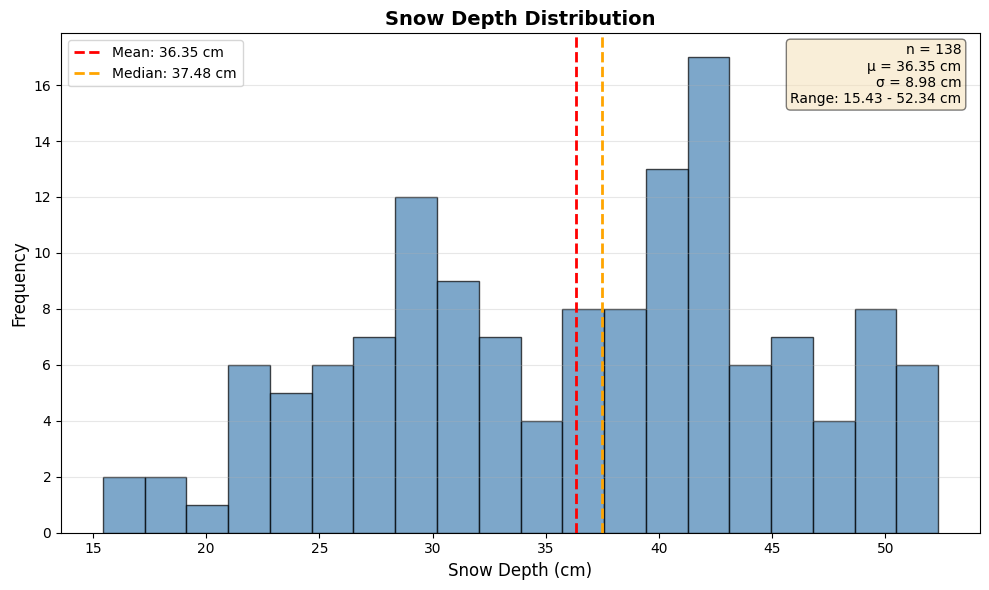

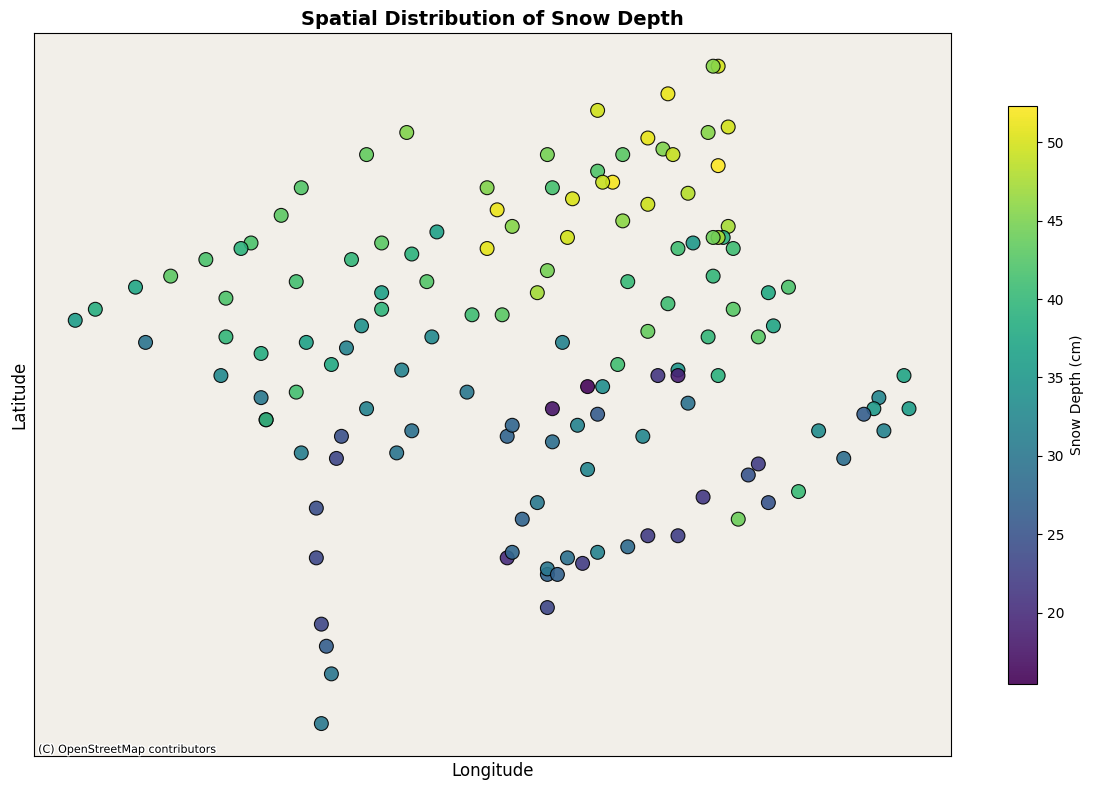

In [15]:
"""
MagnaProbe Data Parser and Analyzer
Processes MagnaProbe snow depth data files and generates visualizations
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import folium
from folium.plugins import HeatMap
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def load_magnaprobe_data(filepath):
    """
    Load MagnaProbe data from .dat or .csv file
    
    Parameters:
    -----------
    filepath : str or Path
        Path to the MagnaProbe data file
    
    Returns:
    --------
    pandas.DataFrame
        Parsed data with proper column types
    """
    # Read the file to find the header
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find the line that starts with "TIMESTAMP" (this is the header)
    header_line = None
    for i, line in enumerate(lines):
        if line.startswith('"TIMESTAMP"'):
            header_line = i
            break
    
    if header_line is None:
        raise ValueError("Could not find header line starting with 'TIMESTAMP'")
    
    # Read the data, skipping metadata and unit rows
    # Skip: header_line + 1 (units row) and header_line + 2 (sample type row)
    df = pd.read_csv(
        filepath,
        skiprows=header_line + 3,  # Skip metadata, header, units, and sample rows
        header=None,
        names=pd.read_csv(filepath, skiprows=header_line, nrows=1).columns,
        na_values=['NAN', ''],
        low_memory=False
    )
    
    # Clean column names (remove quotes)
    df.columns = df.columns.str.replace('"', '')
    
    # Convert numeric columns
    numeric_cols = ['DepthCm', 'BattVolts', 'latitude_a', 'latitude_b', 
                    'Longitude_a', 'Longitude_b', 'HDOP', 'altitudeB',
                    'DepthVolts', 'LatitudeDDDDD', 'LongitudeDDDDD']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convert integer columns
    int_cols = ['RECORD', 'Counter', 'fix_quality', 'nmbr_satellites',
                'month', 'dayofmonth', 'hourofday', 'minutes', 'seconds']
    
    for col in int_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
    # Convert timestamp
    if 'TIMESTAMP' in df.columns:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], errors='coerce')
    
    # Fix coordinate format - convert from degrees + decimal minutes to decimal degrees
    if 'latitude_a' in df.columns and 'latitude_b' in df.columns:
        df['Latitude'] = df['latitude_a'] + df['latitude_b'] / 60.0
    elif 'LatitudeDDDDD' in df.columns:
        # Check if coordinates look wrong (too small)
        if df['LatitudeDDDDD'].abs().max() < 10:
            # These appear to be in a weird format, try to reconstruct
            if 'latitude_a' in df.columns and 'latitude_b' in df.columns:
                df['Latitude'] = df['latitude_a'] + df['latitude_b'] / 60.0
            else:
                df['Latitude'] = df['LatitudeDDDDD']
        else:
            df['Latitude'] = df['LatitudeDDDDD']
    
    if 'Longitude_a' in df.columns and 'Longitude_b' in df.columns:
        df['Longitude'] = df['Longitude_a'] + df['Longitude_b'] / 60.0
    elif 'LongitudeDDDDD' in df.columns:
        if df['LongitudeDDDDD'].abs().max() < 10:
            if 'Longitude_a' in df.columns and 'Longitude_b' in df.columns:
                df['Longitude'] = df['Longitude_a'] + df['Longitude_b'] / 60.0
            else:
                df['Longitude'] = df['LongitudeDDDDD']
        else:
            df['Longitude'] = df['LongitudeDDDDD']
    
    return df


def clean_data(df, min_depth=0, max_depth=129):
    """
    Remove calibration values and invalid measurements
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw MagnaProbe data
    min_depth : float, optional
        Minimum valid depth in cm (default: 0)
    max_depth : float, optional
        Maximum valid depth in cm (default: 129)
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned data with only valid measurements
    """
    # Filter out calibration values (negative and >= 129 cm)
    mask = (df['DepthCm'] >= min_depth) & (df['DepthCm'] < max_depth)
    df_clean = df[mask].copy()
    
    print(f"Original measurements: {len(df)}")
    print(f"Valid measurements: {len(df_clean)}")
    print(f"Removed (calibration/invalid): {len(df) - len(df_clean)}")
    
    return df_clean


def calculate_statistics(df):
    """
    Calculate summary statistics for snow depth data
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    
    Returns:
    --------
    dict
        Dictionary containing statistical measures
    """
    depths = df['DepthCm'].dropna()
    
    stats = {
        'count': len(depths),
        'mean': depths.mean(),
        'median': depths.median(),
        'std': depths.std(),
        'min': depths.min(),
        'max': depths.max(),
        'q25': depths.quantile(0.25),
        'q75': depths.quantile(0.75)
    }
    
    return stats


def plot_histogram(df, bins=20, figsize=(10, 6), save_path=None):
    """
    Create histogram of snow depth distribution
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    bins : int, optional
        Number of histogram bins (default: 20)
    figsize : tuple, optional
        Figure size (width, height)
    save_path : str or Path, optional
        Path to save figure (if None, displays instead)
    """
    depths = df['DepthCm'].dropna()
    stats = calculate_statistics(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create histogram
    n, bins_edges, patches = ax.hist(depths, bins=bins, edgecolor='black', 
                                      color='steelblue', alpha=0.7)
    
    # Add mean and median lines
    ax.axvline(stats['mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {stats['mean']:.2f} cm")
    ax.axvline(stats['median'], color='orange', linestyle='--', linewidth=2,
               label=f"Median: {stats['median']:.2f} cm")
    
    # Labels and title
    ax.set_xlabel('Snow Depth (cm)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Snow Depth Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add stats text box
    stats_text = f"n = {stats['count']}\n"
    stats_text += f"μ = {stats['mean']:.2f} cm\n"
    stats_text += f"σ = {stats['std']:.2f} cm\n"
    stats_text += f"Range: {stats['min']:.2f} - {stats['max']:.2f} cm"
    
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Histogram saved to: {save_path}")
    else:
        plt.show()
    
    return fig, ax


def plot_spatial_map(df, figsize=(12, 8), colormap='viridis', save_path=None):
    """
    Create spatial map of snow depth measurements with basemap
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    figsize : tuple, optional
        Figure size (width, height)
    colormap : str, optional
        Matplotlib colormap name (default: 'viridis')
    save_path : str or Path, optional
        Path to save figure (if None, displays instead)
    """
    # Use proper coordinate columns
    lon_col = 'Longitude' if 'Longitude' in df.columns else 'LongitudeDDDDD'
    lat_col = 'Latitude' if 'Latitude' in df.columns else 'LatitudeDDDDD'
    
    # Try to create map with contextily basemap
    try:
        import geopandas as gpd
        from shapely.geometry import Point
        
        # Create GeoDataFrame
        geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
        
        # Convert to Web Mercator for basemap
        gdf = gdf.to_crs(epsg=3857)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot points
        scatter = ax.scatter(
            gdf.geometry.x, 
            gdf.geometry.y,
            c=df['DepthCm'], 
            cmap=colormap, 
            s=100,
            edgecolor='black', 
            linewidth=0.8, 
            alpha=0.9,
            zorder=5
        )
        
        # Add basemap
        ctx.add_basemap(
            ax, 
            source=ctx.providers.OpenStreetMap.Mapnik,
            attribution_size=8
        )
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax, label='Snow Depth (cm)', shrink=0.8)
        
        # Labels and title
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_title('Spatial Distribution of Snow Depth', fontsize=14, fontweight='bold')
        
        # Remove axis ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        
    except (ImportError, Exception) as e:
        print(f"Could not create basemap (missing geopandas/contextily): {e}")
        print("Falling back to simple scatter plot...")
        
        # Fallback to simple plot
        fig, ax = plt.subplots(figsize=figsize)
        
        scatter = ax.scatter(
            df[lon_col], 
            df[lat_col],
            c=df['DepthCm'], 
            cmap=colormap, 
            s=100,
            edgecolor='black', 
            linewidth=0.8, 
            alpha=0.8
        )
        
        cbar = plt.colorbar(scatter, ax=ax, label='Snow Depth (cm)')
        
        ax.set_xlabel('Longitude (decimal degrees)', fontsize=12)
        ax.set_ylabel('Latitude (decimal degrees)', fontsize=12)
        ax.set_title('Spatial Distribution of Snow Depth', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Spatial map saved to: {save_path}")
    else:
        plt.show()
    
    return fig, ax


def create_interactive_map(df, save_path='snow_depth_interactive_map.html'):
    """
    Create an interactive Folium map with snow depth measurements
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    save_path : str or Path, optional
        Path to save HTML map
    
    Returns:
    --------
    folium.Map
        Interactive map object
    """
    # Use proper coordinate columns
    lon_col = 'Longitude' if 'Longitude' in df.columns else 'LongitudeDDDDD'
    lat_col = 'Latitude' if 'Latitude' in df.columns else 'LatitudeDDDDD'
    
    # Calculate center of measurements
    center_lat = df[lat_col].mean()
    center_lon = df[lon_col].mean()
    
    print(f"Map center: Lat={center_lat:.6f}, Lon={center_lon:.6f}")
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=15,
        tiles='OpenStreetMap'
    )
    
    # Add satellite imagery option
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite Imagery',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Normalize depths for color mapping
    norm = Normalize(vmin=df['DepthCm'].min(), vmax=df['DepthCm'].max())
    cmap = plt.cm.get_cmap('viridis')
    
    # Add circle markers for each measurement
    for idx, row in df.iterrows():
        color_val = cmap(norm(row['DepthCm']))
        color_hex = '#{:02x}{:02x}{:02x}'.format(
            int(color_val[0]*255), 
            int(color_val[1]*255), 
            int(color_val[2]*255)
        )
        
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=6,
            popup=f"Depth: {row['DepthCm']:.2f} cm<br>Time: {row['TIMESTAMP']}",
            tooltip=f"{row['DepthCm']:.2f} cm",
            color='black',
            fillColor=color_hex,
            fillOpacity=0.8,
            weight=1
        ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save map
    m.save(save_path)
    print(f"Interactive map saved to: {save_path}")
    
    return m


def main():
    """
    Main function to process MagnaProbe data and create visualizations
    """
    # Example usage
    filepath = 'Probe49687_0.dat'
    
    print("Loading MagnaProbe data...")
    df = load_magnaprobe_data(filepath)
    
    print("\nCleaning data...")
    df_clean = clean_data(df)
    
    print("\nCalculating statistics...")
    stats = calculate_statistics(df_clean)
    print("\nSummary Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value:.2f}")
    
    print("\nGenerating histogram...")
    plot_histogram(df_clean, save_path='snow_depth_histogram.png')
    
    print("\nGenerating spatial map...")
    plot_spatial_map(df_clean, save_path='snow_depth_map.png')
    
    print("\nGenerating interactive map...")
    create_interactive_map(df_clean, save_path='snow_depth_interactive_map.html')
    
    print("\nDone! Check output files for visualizations.")
    print("  - snow_depth_histogram.png")
    print("  - snow_depth_map.png")
    print("  - snow_depth_interactive_map.html (open in browser)")


# if __name__ == '__main__':
#     main()

main()

In [13]:
"""
MagnaProbe Data Parser and Analyzer
Processes MagnaProbe snow depth data files and generates visualizations
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import folium
from folium.plugins import HeatMap
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def load_magnaprobe_data(filepath):
    """
    Load MagnaProbe data from .dat or .csv file
    
    Parameters:
    -----------
    filepath : str or Path
        Path to the MagnaProbe data file
    
    Returns:
    --------
    pandas.DataFrame
        Parsed data with proper column types
    """
    # Read the file to find the header
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find the line that starts with "TIMESTAMP" (this is the header)
    header_line = None
    for i, line in enumerate(lines):
        if line.startswith('"TIMESTAMP"'):
            header_line = i
            break
    
    if header_line is None:
        raise ValueError("Could not find header line starting with 'TIMESTAMP'")
    
    # Read the data, skipping metadata and unit rows
    # Skip: header_line + 1 (units row) and header_line + 2 (sample type row)
    df = pd.read_csv(
        filepath,
        skiprows=header_line + 3,  # Skip metadata, header, units, and sample rows
        header=None,
        names=pd.read_csv(filepath, skiprows=header_line, nrows=1).columns,
        na_values=['NAN', ''],
        low_memory=False
    )
    
    # Clean column names (remove quotes)
    df.columns = df.columns.str.replace('"', '')
    
    # Convert numeric columns
    numeric_cols = ['DepthCm', 'BattVolts', 'latitude_a', 'latitude_b', 
                    'Longitude_a', 'Longitude_b', 'HDOP', 'altitudeB',
                    'DepthVolts', 'LatitudeDDDDD', 'LongitudeDDDDD']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convert integer columns
    int_cols = ['RECORD', 'Counter', 'fix_quality', 'nmbr_satellites',
                'month', 'dayofmonth', 'hourofday', 'minutes', 'seconds']
    
    for col in int_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
    # Convert timestamp
    if 'TIMESTAMP' in df.columns:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], errors='coerce')
    
    return df


def clean_data(df, min_depth=0, max_depth=129):
    """
    Remove calibration values and invalid measurements
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw MagnaProbe data
    min_depth : float, optional
        Minimum valid depth in cm (default: 0)
    max_depth : float, optional
        Maximum valid depth in cm (default: 129)
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned data with only valid measurements
    """
    # Filter out calibration values (negative and >= 129 cm)
    mask = (df['DepthCm'] >= min_depth) & (df['DepthCm'] < max_depth)
    df_clean = df[mask].copy()
    
    print(f"Original measurements: {len(df)}")
    print(f"Valid measurements: {len(df_clean)}")
    print(f"Removed (calibration/invalid): {len(df) - len(df_clean)}")
    
    return df_clean


def calculate_statistics(df):
    """
    Calculate summary statistics for snow depth data
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    
    Returns:
    --------
    dict
        Dictionary containing statistical measures
    """
    depths = df['DepthCm'].dropna()
    
    stats = {
        'count': len(depths),
        'mean': depths.mean(),
        'median': depths.median(),
        'std': depths.std(),
        'min': depths.min(),
        'max': depths.max(),
        'q25': depths.quantile(0.25),
        'q75': depths.quantile(0.75)
    }
    
    return stats


def plot_histogram(df, bins=20, figsize=(10, 6), save_path=None):
    """
    Create histogram of snow depth distribution
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    bins : int, optional
        Number of histogram bins (default: 20)
    figsize : tuple, optional
        Figure size (width, height)
    save_path : str or Path, optional
        Path to save figure (if None, displays instead)
    """
    depths = df['DepthCm'].dropna()
    stats = calculate_statistics(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create histogram
    n, bins_edges, patches = ax.hist(depths, bins=bins, edgecolor='black', 
                                      color='steelblue', alpha=0.7)
    
    # Add mean and median lines
    ax.axvline(stats['mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {stats['mean']:.2f} cm")
    ax.axvline(stats['median'], color='orange', linestyle='--', linewidth=2,
               label=f"Median: {stats['median']:.2f} cm")
    
    # Labels and title
    ax.set_xlabel('Snow Depth (cm)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Snow Depth Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add stats text box
    stats_text = f"n = {stats['count']}\n"
    stats_text += f"μ = {stats['mean']:.2f} cm\n"
    stats_text += f"σ = {stats['std']:.2f} cm\n"
    stats_text += f"Range: {stats['min']:.2f} - {stats['max']:.2f} cm"
    
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Histogram saved to: {save_path}")
    else:
        plt.show()
    
    return fig, ax


def plot_spatial_map(df, figsize=(12, 8), colormap='viridis', save_path=None):
    """
    Create spatial map of snow depth measurements with basemap
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    figsize : tuple, optional
        Figure size (width, height)
    colormap : str, optional
        Matplotlib colormap name (default: 'viridis')
    save_path : str or Path, optional
        Path to save figure (if None, displays instead)
    """
    # Try to create map with contextily basemap
    try:
        import geopandas as gpd
        from shapely.geometry import Point
        
        # Create GeoDataFrame
        geometry = [Point(xy) for xy in zip(df['LongitudeDDDDD'], df['LatitudeDDDDD'])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
        
        # Convert to Web Mercator for basemap
        gdf = gdf.to_crs(epsg=3857)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot points
        scatter = ax.scatter(
            gdf.geometry.x, 
            gdf.geometry.y,
            c=df['DepthCm'], 
            cmap=colormap, 
            s=100,
            edgecolor='black', 
            linewidth=0.8, 
            alpha=0.9,
            zorder=5
        )
        
        # Add basemap
        ctx.add_basemap(
            ax, 
            source=ctx.providers.OpenStreetMap.Mapnik,
            attribution_size=8
        )
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax, label='Snow Depth (cm)', shrink=0.8)
        
        # Labels and title
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_title('Spatial Distribution of Snow Depth', fontsize=14, fontweight='bold')
        
        # Remove axis ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        
    except (ImportError, Exception) as e:
        print(f"Could not create basemap (missing geopandas/contextily): {e}")
        print("Falling back to simple scatter plot...")
        
        # Fallback to simple plot
        fig, ax = plt.subplots(figsize=figsize)
        
        scatter = ax.scatter(
            df['LongitudeDDDDD'], 
            df['LatitudeDDDDD'],
            c=df['DepthCm'], 
            cmap=colormap, 
            s=100,
            edgecolor='black', 
            linewidth=0.8, 
            alpha=0.8
        )
        
        cbar = plt.colorbar(scatter, ax=ax, label='Snow Depth (cm)')
        
        ax.set_xlabel('Longitude (decimal degrees)', fontsize=12)
        ax.set_ylabel('Latitude (decimal degrees)', fontsize=12)
        ax.set_title('Spatial Distribution of Snow Depth', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Spatial map saved to: {save_path}")
    else:
        plt.show()
    
    return fig, ax


def create_interactive_map(df, save_path='snow_depth_interactive_map.html'):
    """
    Create an interactive Folium map with snow depth measurements
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    save_path : str or Path, optional
        Path to save HTML map
    
    Returns:
    --------
    folium.Map
        Interactive map object
    """
    # Calculate center of measurements
    center_lat = df['LatitudeDDDDD'].mean()
    center_lon = df['LongitudeDDDDD'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=15,
        tiles='OpenStreetMap'
    )
    
    # Add satellite imagery option
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite Imagery',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Normalize depths for color mapping
    norm = Normalize(vmin=df['DepthCm'].min(), vmax=df['DepthCm'].max())
    cmap = plt.cm.get_cmap('viridis')
    
    # Add circle markers for each measurement
    for idx, row in df.iterrows():
        color_val = cmap(norm(row['DepthCm']))
        color_hex = '#{:02x}{:02x}{:02x}'.format(
            int(color_val[0]*255), 
            int(color_val[1]*255), 
            int(color_val[2]*255)
        )
        
        folium.CircleMarker(
            location=[row['LatitudeDDDDD'], row['LongitudeDDDDD']],
            radius=6,
            popup=f"Depth: {row['DepthCm']:.2f} cm<br>Time: {row['TIMESTAMP']}",
            tooltip=f"{row['DepthCm']:.2f} cm",
            color='black',
            fillColor=color_hex,
            fillOpacity=0.8,
            weight=1
        ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save map
    m.save(save_path)
    print(f"Interactive map saved to: {save_path}")
    
    return m


def main():
    """
    Main function to process MagnaProbe data and create visualizations
    """
    # Example usage
    filepath = 'Probe49687_0.dat'
    
    print("Loading MagnaProbe data...")
    df = load_magnaprobe_data(filepath)
    
    print("\nCleaning data...")
    df_clean = clean_data(df)
    
    print("\nCalculating statistics...")
    stats = calculate_statistics(df_clean)
    print("\nSummary Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value:.2f}")
    
    print("\nGenerating histogram...")
    plot_histogram(df_clean, save_path='snow_depth_histogram.png')
    
    print("\nGenerating spatial map...")
    plot_spatial_map(df_clean, save_path='snow_depth_map.png')
    
    print("\nGenerating interactive map...")
    create_interactive_map(df_clean, save_path='snow_depth_interactive_map.html')
    
    print("\nDone! Check output files for visualizations.")
    print("  - snow_depth_histogram.png")
    print("  - snow_depth_map.png")
    print("  - snow_depth_interactive_map.html (open in browser)")


# if __name__ == '__main__':
#     main()

Loading MagnaProbe data...

Cleaning data...
Original measurements: 142
Valid measurements: 138
Removed (calibration/invalid): 4

Calculating statistics...

Summary Statistics:
  count: 138.00
  mean: 36.35
  median: 37.48
  std: 8.98
  min: 15.43
  max: 52.34
  q25: 29.64
  q75: 42.88

Generating histogram...
Histogram saved to: snow_depth_histogram.png

Generating spatial map...


/Users/ibrahim/.pyenv/versions/3.11.5/lib/python3.11/site-packages/contextily/tile.py:662: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


Spatial map saved to: snow_depth_map.png

Generating interactive map...
Interactive map saved to: snow_depth_interactive_map.html

Done! Check output files for visualizations.
  - snow_depth_histogram.png
  - snow_depth_map.png
  - snow_depth_interactive_map.html (open in browser)


/var/folders/d9/2l4fcqx95nzd848mp5lw4g0m0000gn/T/ipykernel_55363/1751488086.py:337: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


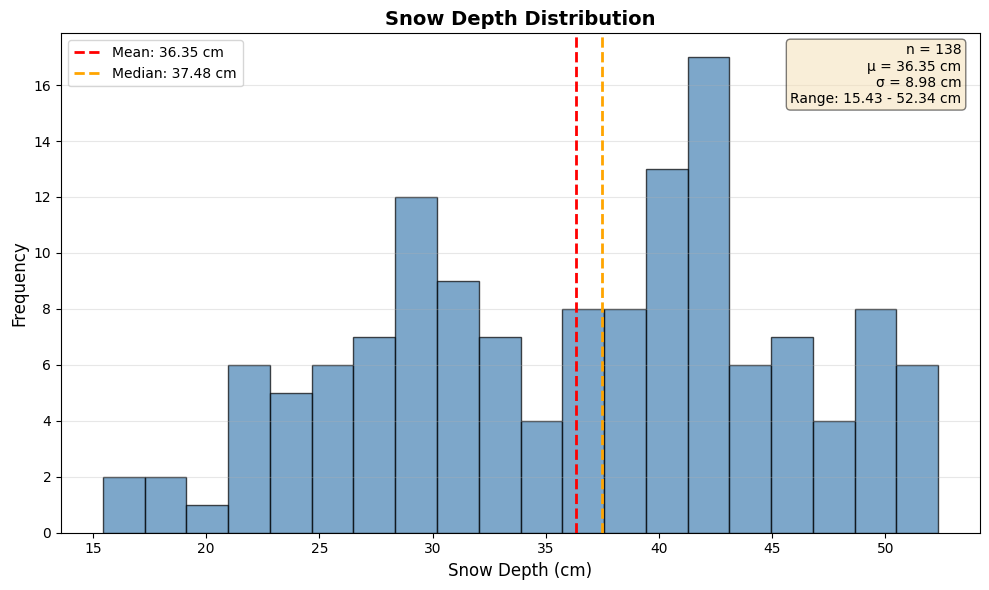

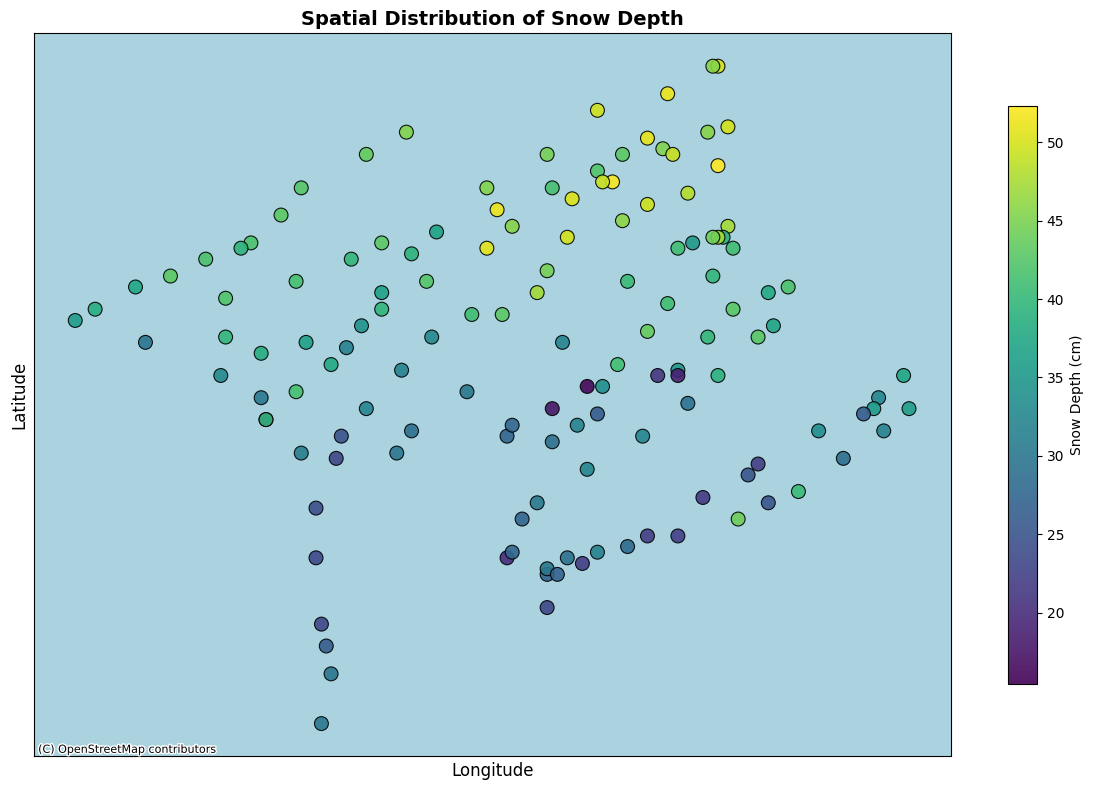

In [14]:
main()

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = Path("Probe49687_0.dat")  # update if needed
SKIPROWS = [0, 2, 3]  # TOA5: metadata, units, and processing rows

df = pd.read_csv(DATA_PATH, skiprows=SKIPROWS)
df.head()


,TIMESTAMP,RECORD,Counter,DepthCm,BattVolts,latitude_a,latitude_b,Longitude_a,Longitude_b,fix_quality,...,altitudeB,DepthVolts,LatitudeDDDDD,LongitudeDDDDD,month,dayofmonth,hourofday,minutes,seconds,microseconds
0,2026-01-02 16:34:16.5,2195,100001,-0.053,13.17,43,55.9026,-115,-40.1403,2,...,1870.2,0.063,0.931710,-0.669005,1,2,16,34,16,500000
1,2026-01-02 16:34:17.25,2196,100002,129.800,13.17,43,55.9026,-115,-40.1403,2,...,1870.2,8.490,0.931710,-0.669005,1,2,16,34,17,250000
2,2026-01-02 16:34:18,2197,100003,23.300,13.12,43,55.9665,-115,-40.0531,2,...,1870.6,1.579,0.932775,-0.667552,1,2,16,34,18,0
3,2026-01-02 16:34:19,2198,100004,27.350,13.12,43,55.9671,-115,-40.0531,2,...,1871.9,1.842,0.932785,-0.667552,1,2,16,34,19,0
4,2026-01-02 16:34:20,2199,100005,30.050,13.12,43,55.9672,-115,-40.0531,2,...,1871.9,2.017,0.932787,-0.667552,1,2,16,34,20,0


In [2]:
df.shape, df.columns.tolist()


((142, 22),
 ['TIMESTAMP',
  'RECORD',
  'Counter',
  'DepthCm',
  'BattVolts',
  'latitude_a',
  'latitude_b',
  'Longitude_a',
  'Longitude_b',
  'fix_quality',
  'nmbr_satellites',
  'HDOP',
  'altitudeB',
  'DepthVolts',
  'LatitudeDDDDD',
  'LongitudeDDDDD',
  'month',
  'dayofmonth',
  'hourofday',
  'minutes',
  'seconds',
  'microseconds'])

## Parse timestamps and apply depth QC

We:
- parse `TIMESTAMP`
- coerce `DepthCm` to numeric
- create `DepthCm_clean` and set invalid calibration/error values to NA using:

\[ 0 \le depth \le 129 \]


In [3]:
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], errors="coerce")

df["DepthCm"] = pd.to_numeric(df["DepthCm"], errors="coerce")
df["DepthCm_clean"] = df["DepthCm"].where((df["DepthCm"] >= 0) & (df["DepthCm"] <= 129))

# Quick counts
{
    "n_rows": len(df),
    "n_depth_numeric": int(df["DepthCm"].notna().sum()),
    "n_depth_clean": int(df["DepthCm_clean"].notna().sum()),
    "n_removed_by_qc": int(df["DepthCm"].notna().sum() - df["DepthCm_clean"].notna().sum()),
    "min_clean": float(df["DepthCm_clean"].min()),
    "max_clean": float(df["DepthCm_clean"].max()),
}


{'n_rows': 142,
 'n_depth_numeric': 142,
 'n_depth_clean': 138,
 'n_removed_by_qc': 4,
 'min_clean': 15.43,
 'max_clean': 52.34}

In [4]:
df[["DepthCm", "DepthCm_clean"]].describe()


,DepthCm,DepthCm_clean
count,142.000000,138.000000
mean,37.155092,36.351594
std,14.842786,8.976857
min,-0.053000,15.430000
25%,29.437500,29.637500
50%,37.485000,37.485000
75%,42.935000,42.877500
max,129.800000,52.340000


## Recompute lat/lon (decimal degrees)

To avoid ambiguity, recompute decimal degrees from:

- `latitude_a` (degrees), `latitude_b` (minutes)  
- `Longitude_a` (degrees), `Longitude_b` (minutes)

Conversion:
\[ dd = sign(deg) * (|deg| + minutes/60) \]


In [5]:
def dms_degmin_to_dd(deg: pd.Series, minutes: pd.Series) -> pd.Series:
    deg = pd.to_numeric(deg, errors="coerce")
    minutes = pd.to_numeric(minutes, errors="coerce").abs()
    dd = deg.abs() + minutes / 60.0
    dd = np.where(deg < 0, -dd, dd)
    return pd.Series(dd, index=deg.index, dtype="float64")

df["lat_dd"] = dms_degmin_to_dd(df["latitude_a"], df["latitude_b"])
df["lon_dd"] = dms_degmin_to_dd(df["Longitude_a"], df["Longitude_b"])

df[["latitude_a","latitude_b","lat_dd","Longitude_a","Longitude_b","lon_dd"]].head()


,latitude_a,latitude_b,lat_dd,Longitude_a,Longitude_b,lon_dd
0,43,55.9026,43.931710,-115,-40.1403,-115.669005
1,43,55.9026,43.931710,-115,-40.1403,-115.669005
2,43,55.9665,43.932775,-115,-40.0531,-115.667552
3,43,55.9671,43.932785,-115,-40.0531,-115.667552
4,43,55.9672,43.932787,-115,-40.0531,-115.667552


In [6]:
# Sanity checks: ranges and missingness
{
    "lat_range": (float(df["lat_dd"].min()), float(df["lat_dd"].max())),
    "lon_range": (float(df["lon_dd"].min()), float(df["lon_dd"].max())),
    "n_latlon_ok": int((df["lat_dd"].notna() & df["lon_dd"].notna()).sum()),
}


{'lat_range': (43.93171, 43.93293833333333),
 'lon_range': (-115.669005, -115.66743166666667),
 'n_latlon_ok': 142}

## Plot 1: Snow depth histogram (QC applied)

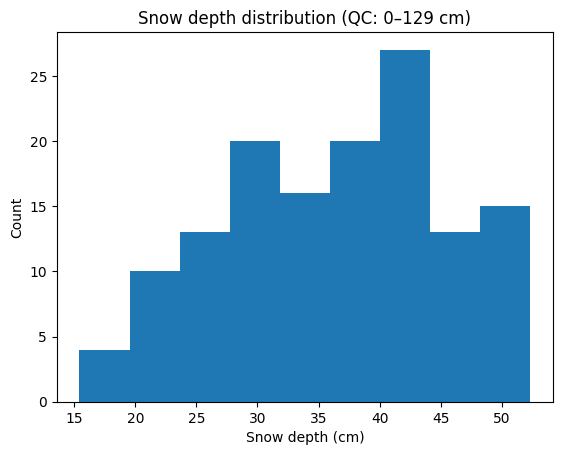

In [7]:
vals = df["DepthCm_clean"].dropna().to_numpy()

plt.figure()
plt.hist(vals, bins="auto")
plt.xlabel("Snow depth (cm)")
plt.ylabel("Count")
plt.title("Snow depth distribution (QC: 0–129 cm)")
plt.show()


## Plot 2: Depth vs time (QC applied)

Useful for spotting pauses or sequences.


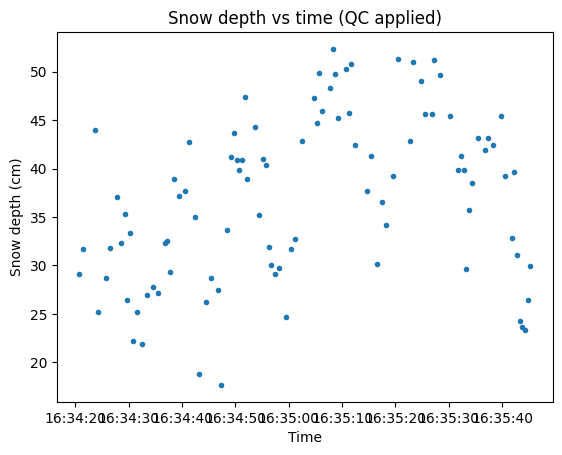

In [8]:
plt.figure()
plt.plot(df["TIMESTAMP"], df["DepthCm_clean"], marker=".", linestyle="none")
plt.xlabel("Time")
plt.ylabel("Snow depth (cm)")
plt.title("Snow depth vs time (QC applied)")
plt.show()


## Map overlays (basemap under points)

Two options are provided:

### A) Quick interactive map (recommended for browsing)
Uses **folium** and writes an HTML map.

### B) Static map with basemap tiles
Uses **geopandas + contextily** to draw a basemap under your points in matplotlib.

If you don't have these installed:
- `pip install folium`
- `pip install geopandas contextily pyproj`


In [9]:
# Option A: Folium interactive map (writes HTML)
def make_folium_map(df, out_html="outputs/depth_map.html"):
    try:
        import folium
    except ImportError:
        print("folium not installed (pip install folium). Skipping.")
        return None

    ok = df["lat_dd"].notna() & df["lon_dd"].notna()
    if ok.sum() == 0:
        print("No valid lat/lon to map.")
        return None

    lat0 = float(df.loc[ok, "lat_dd"].median())
    lon0 = float(df.loc[ok, "lon_dd"].median())
    m = folium.Map(location=[lat0, lon0], zoom_start=14, control_scale=True)

    # Add points (depth in popup if available)
    for la, lo, d in zip(df.loc[ok, "lat_dd"], df.loc[ok, "lon_dd"], df.loc[ok, "DepthCm_clean"]):
        popup = None if pd.isna(d) else f"Depth: {float(d):.1f} cm"
        folium.CircleMarker(
            location=[float(la), float(lo)],
            radius=3,
            popup=popup,
        ).add_to(m)

    Path(out_html).parent.mkdir(exist_ok=True)
    m.save(out_html)
    return out_html

make_folium_map(df)


'outputs/depth_map.html'

/Users/ibrahim/.pyenv/versions/3.11.5/lib/python3.11/site-packages/contextily/tile.py:662: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


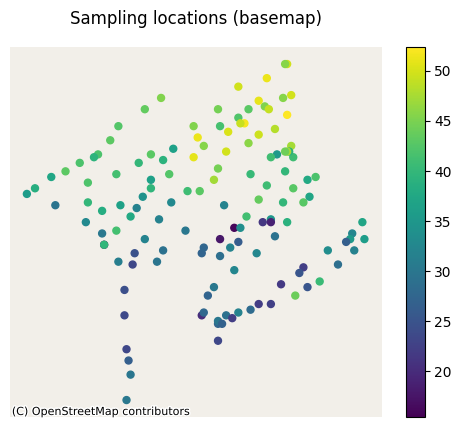

In [10]:
# Option B: Static basemap overlay using contextily
def plot_static_basemap(df):
    try:
        import geopandas as gpd
        import contextily as cx
    except ImportError:
        print("geopandas/contextily not installed. (pip install geopandas contextily pyproj)")
        return

    ok = df["lat_dd"].notna() & df["lon_dd"].notna()
    gdf = gpd.GeoDataFrame(
        df.loc[ok].copy(),
        geometry=gpd.points_from_xy(df.loc[ok, "lon_dd"], df.loc[ok, "lat_dd"]),
        crs="EPSG:4326",
    )

    # Reproject to Web Mercator for basemap tiles
    gdf_3857 = gdf.to_crs(epsg=3857)

    # Plot points, colored by depth where available
    plt.figure()
    ax = plt.gca()

    has_depth = gdf_3857["DepthCm_clean"].notna().any()
    if has_depth:
        gdf_3857.plot(
            ax=ax,
            column="DepthCm_clean",
            legend=True,
            markersize=25,
        )
    else:
        gdf_3857.plot(ax=ax, markersize=25)

    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    plt.title("Sampling locations (basemap)")
    plt.show()

plot_static_basemap(df)


## Export a cleaned table (for scripting later)

This creates a “cleaned” CSV with:
- `DepthCm_clean`
- `lat_dd`, `lon_dd`
- original columns preserved


In [ ]:
out = Path("outputs")
out.mkdir(exist_ok=True)

clean_path = out / "magnaprobe_cleaned.csv"
df.to_csv(clean_path, index=False)
clean_path


Loading MagnaProbe data...

Cleaning data...
Original measurements: 142
Valid measurements: 138
Removed (calibration/invalid): 4

Calculating statistics...

Summary Statistics:
  count: 138.00
  mean: 36.35
  median: 37.48
  std: 8.98
  min: 15.43
  max: 52.34
  q25: 29.64
  q75: 42.88

Generating histogram...
Histogram saved to: snow_depth_histogram.png

Generating spatial map...


/Users/ibrahim/.pyenv/versions/3.11.5/lib/python3.11/site-packages/contextily/tile.py:662: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


Spatial map saved to: snow_depth_map.png

Generating interactive map...
Map center: Lat=43.932853, Lon=-114.332445
Interactive map saved to: snow_depth_interactive_map.html
  Open snow_depth_interactive_map.html in your web browser to interact with the map!

Done! Check output files for visualizations.
  - snow_depth_histogram.png
  - snow_depth_map.png
  - snow_depth_interactive_map.html (open in browser)


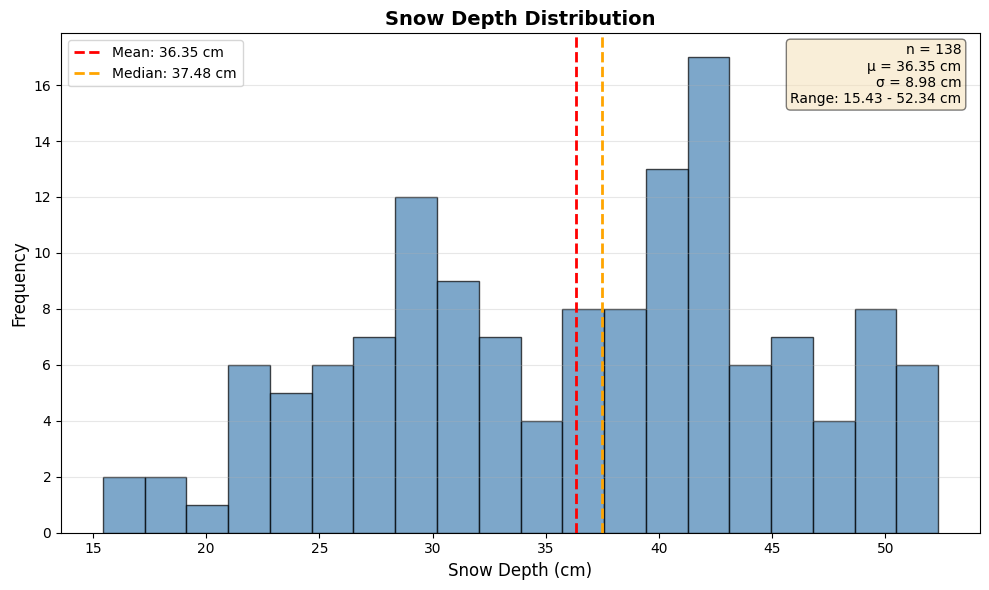

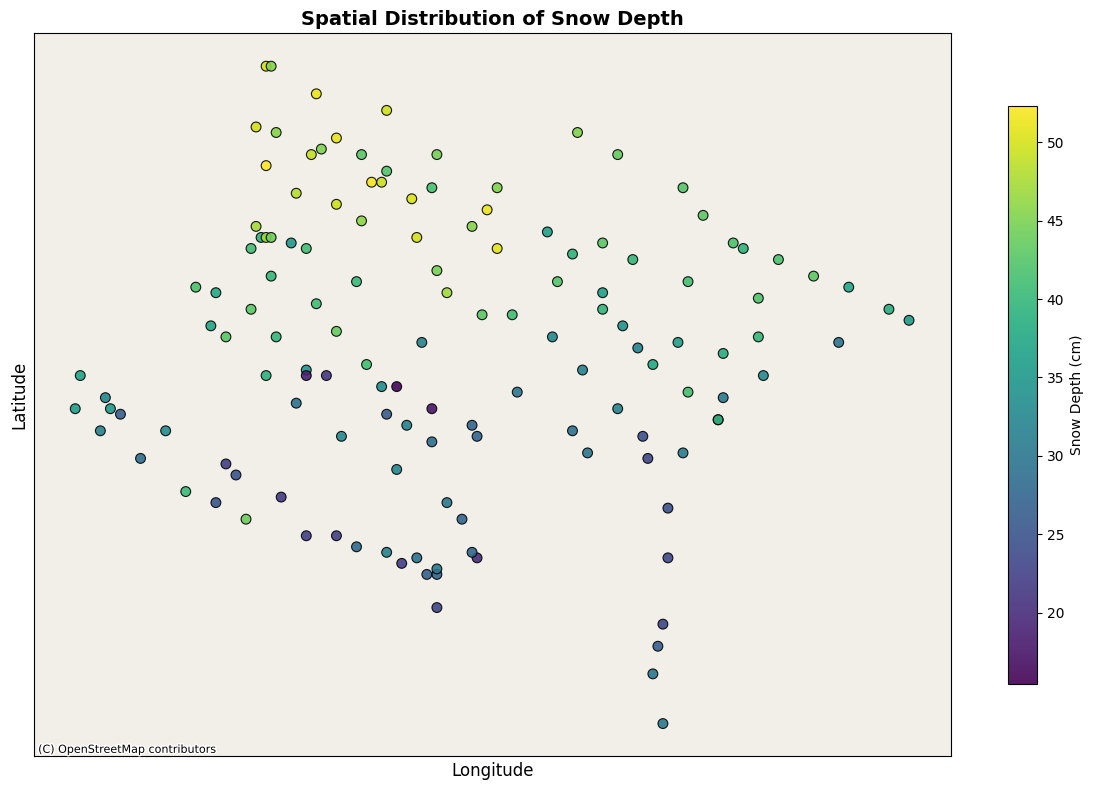

In [ ]:
"""
MagnaProbe Data Parser and Analyzer
Processes MagnaProbe snow depth data files and generates visualizations
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import folium
from folium.plugins import HeatMap
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def load_magnaprobe_data(filepath):
    """
    Load MagnaProbe data from .dat or .csv file
    
    Parameters:
    -----------
    filepath : str or Path
        Path to the MagnaProbe data file
    
    Returns:
    --------
    pandas.DataFrame
        Parsed data with proper column types
    """
    # Read the file to find the header
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find the line that starts with "TIMESTAMP" (this is the header)
    header_line = None
    for i, line in enumerate(lines):
        if line.startswith('"TIMESTAMP"'):
            header_line = i
            break
    
    if header_line is None:
        raise ValueError("Could not find header line starting with 'TIMESTAMP'")
    
    # Read the data, skipping metadata and unit rows
    # Skip: header_line + 1 (units row) and header_line + 2 (sample type row)
    df = pd.read_csv(
        filepath,
        skiprows=header_line + 3,  # Skip metadata, header, units, and sample rows
        header=None,
        names=pd.read_csv(filepath, skiprows=header_line, nrows=1).columns,
        na_values=['NAN', ''],
        low_memory=False
    )
    
    # Clean column names (remove quotes)
    df.columns = df.columns.str.replace('"', '')
    
    # Convert numeric columns
    numeric_cols = ['DepthCm', 'BattVolts', 'latitude_a', 'latitude_b', 
                    'Longitude_a', 'Longitude_b', 'HDOP', 'altitudeB',
                    'DepthVolts', 'LatitudeDDDDD', 'LongitudeDDDDD']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Convert integer columns
    int_cols = ['RECORD', 'Counter', 'fix_quality', 'nmbr_satellites',
                'month', 'dayofmonth', 'hourofday', 'minutes', 'seconds']
    
    for col in int_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
    # Convert timestamp
    if 'TIMESTAMP' in df.columns:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], errors='coerce')
    
    # Convert coordinates from degrees + decimal minutes to decimal degrees
    # Formula: dd = sign(deg) * (|deg| + minutes/60)
    if 'latitude_a' in df.columns and 'latitude_b' in df.columns:
        df['Latitude'] = np.sign(df['latitude_a']) * (np.abs(df['latitude_a']) + df['latitude_b'] / 60.0)
    else:
        raise ValueError("Missing latitude_a and latitude_b columns")
    
    if 'Longitude_a' in df.columns and 'Longitude_b' in df.columns:
        df['Longitude'] = np.sign(df['Longitude_a']) * (np.abs(df['Longitude_a']) + df['Longitude_b'] / 60.0)
    else:
        raise ValueError("Missing Longitude_a and Longitude_b columns")
    
    return df


def clean_data(df, min_depth=0, max_depth=129):
    """
    Remove calibration values and invalid measurements
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw MagnaProbe data
    min_depth : float, optional
        Minimum valid depth in cm (default: 0)
    max_depth : float, optional
        Maximum valid depth in cm (default: 129)
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned data with only valid measurements
    """
    # Filter out calibration values (negative and >= 129 cm)
    mask = (df['DepthCm'] >= min_depth) & (df['DepthCm'] < max_depth)
    df_clean = df[mask].copy()
    
    print(f"Original measurements: {len(df)}")
    print(f"Valid measurements: {len(df_clean)}")
    print(f"Removed (calibration/invalid): {len(df) - len(df_clean)}")
    
    return df_clean


def calculate_statistics(df):
    """
    Calculate summary statistics for snow depth data
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    
    Returns:
    --------
    dict
        Dictionary containing statistical measures
    """
    depths = df['DepthCm'].dropna()
    
    stats = {
        'count': len(depths),
        'mean': depths.mean(),
        'median': depths.median(),
        'std': depths.std(),
        'min': depths.min(),
        'max': depths.max(),
        'q25': depths.quantile(0.25),
        'q75': depths.quantile(0.75)
    }
    
    return stats


def plot_histogram(df, bins=20, figsize=(10, 6), save_path=None):
    """
    Create histogram of snow depth distribution
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    bins : int, optional
        Number of histogram bins (default: 20)
    figsize : tuple, optional
        Figure size (width, height)
    save_path : str or Path, optional
        Path to save figure (if None, displays instead)
    """
    depths = df['DepthCm'].dropna()
    stats = calculate_statistics(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create histogram
    n, bins_edges, patches = ax.hist(depths, bins=bins, edgecolor='black', 
                                      color='steelblue', alpha=0.7)
    
    # Add mean and median lines
    ax.axvline(stats['mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {stats['mean']:.2f} cm")
    ax.axvline(stats['median'], color='orange', linestyle='--', linewidth=2,
               label=f"Median: {stats['median']:.2f} cm")
    
    # Labels and title
    ax.set_xlabel('Snow Depth (cm)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Snow Depth Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add stats text box
    stats_text = f"n = {stats['count']}\n"
    stats_text += f"μ = {stats['mean']:.2f} cm\n"
    stats_text += f"σ = {stats['std']:.2f} cm\n"
    stats_text += f"Range: {stats['min']:.2f} - {stats['max']:.2f} cm"
    
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Histogram saved to: {save_path}")
    else:
        plt.show()
    
    return fig, ax


def plot_spatial_map(df, figsize=(12, 8), colormap='viridis', save_path=None):
    """
    Create spatial map of snow depth measurements with basemap
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    figsize : tuple, optional
        Figure size (width, height)
    colormap : str, optional
        Matplotlib colormap name (default: 'viridis')
    save_path : str or Path, optional
        Path to save figure (if None, displays instead)
    """
    # Use Latitude and Longitude columns
    lon_col = 'Longitude'
    lat_col = 'Latitude'
    
    # Try to create map with contextily basemap
    try:
        import geopandas as gpd
        from shapely.geometry import Point
        
        # Create GeoDataFrame
        geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
        
        # Convert to Web Mercator for basemap
        gdf = gdf.to_crs(epsg=3857)
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot points
        scatter = ax.scatter(
            gdf.geometry.x, 
            gdf.geometry.y,
            c=df['DepthCm'], 
            cmap=colormap, 
            s=20,
            edgecolor='black', 
            linewidth=0.8, 
            alpha=0.9,
            zorder=5
        )
        
        # Add basemap with appropriate zoom level
        ctx.add_basemap(
            ax, 
            source=ctx.providers.OpenStreetMap.Mapnik,
            attribution_size=8,
            zoom='auto'  # Let contextily determine appropriate zoom
        )
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax, label='Snow Depth (cm)', shrink=0.8)
        
        # Labels and title
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_title('Spatial Distribution of Snow Depth', fontsize=14, fontweight='bold')
        
        # Remove axis ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        
    except (ImportError, Exception) as e:
        print(f"Could not create basemap (missing geopandas/contextily): {e}")
        print("Falling back to simple scatter plot...")
        
        # Fallback to simple plot
        fig, ax = plt.subplots(figsize=figsize)
        
        scatter = ax.scatter(
            df[lon_col], 
            df[lat_col],
            c=df['DepthCm'], 
            cmap=colormap, 
            s=100,
            edgecolor='black', 
            linewidth=0.8, 
            alpha=0.8
        )
        
        cbar = plt.colorbar(scatter, ax=ax, label='Snow Depth (cm)')
        
        ax.set_xlabel('Longitude (decimal degrees)', fontsize=12)
        ax.set_ylabel('Latitude (decimal degrees)', fontsize=12)
        ax.set_title('Spatial Distribution of Snow Depth', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Spatial map saved to: {save_path}")
    else:
        plt.show()
    
    return fig, ax


def create_interactive_map(df, save_path='snow_depth_interactive_map.html'):
    """
    Create an interactive Folium map with snow depth measurements
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned MagnaProbe data
    save_path : str or Path, optional
        Path to save HTML map
    
    Returns:
    --------
    folium.Map
        Interactive map object
    """
    # Use Latitude and Longitude columns
    lon_col = 'Longitude'
    lat_col = 'Latitude'
    
    # Calculate center of measurements
    center_lat = df[lat_col].mean()
    center_lon = df[lon_col].mean()
    
    print(f"Map center: Lat={center_lat:.6f}, Lon={center_lon:.6f}")
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=17,
        tiles='OpenStreetMap'
    )
    
    # Add satellite imagery option
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite Imagery',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Normalize depths for color mapping using matplotlib.colormaps
    norm = Normalize(vmin=df['DepthCm'].min(), vmax=df['DepthCm'].max())
    cmap = plt.colormaps.get_cmap('viridis')
    
    # Add circle markers for each measurement
    for idx, row in df.iterrows():
        color_val = cmap(norm(row['DepthCm']))
        color_hex = '#{:02x}{:02x}{:02x}'.format(
            int(color_val[0]*255), 
            int(color_val[1]*255), 
            int(color_val[2]*255)
        )
        
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=6,
            popup=f"Depth: {row['DepthCm']:.2f} cm<br>Time: {row['TIMESTAMP']}",
            tooltip=f"{row['DepthCm']:.2f} cm",
            color='black',
            fillColor=color_hex,
            fillOpacity=0.8,
            weight=1
        ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save map
    m.save(save_path)
    print(f"Interactive map saved to: {save_path}")
    print(f"  Open {save_path} in your web browser to interact with the map!")
    
    return m


def main():
    """
    Main function to process MagnaProbe data and create visualizations
    """
    # Example usage
    filepath = 'Probe49687_0.dat'
    
    print("Loading MagnaProbe data...")
    df = load_magnaprobe_data(filepath)
    
    print("\nCleaning data...")
    df_clean = clean_data(df)
    
    print("\nCalculating statistics...")
    stats = calculate_statistics(df_clean)
    print("\nSummary Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value:.2f}")
    
    print("\nGenerating histogram...")
    plot_histogram(df_clean, save_path='snow_depth_histogram.png')
    
    print("\nGenerating spatial map...")
    plot_spatial_map(df_clean, save_path='snow_depth_map.png')
    
    print("\nGenerating interactive map...")
    create_interactive_map(df_clean, save_path='snow_depth_interactive_map.html')
    
    print("\nDone! Check output files for visualizations.")
    print("  - snow_depth_histogram.png")
    print("  - snow_depth_map.png")
    print("  - snow_depth_interactive_map.html (open in browser)")


main()